In [1]:

import sys
import os
import subprocess


def _pip_install(args):
    """Run pip install in the current interpreter non-interactively."""
    cmd = [sys.executable, "-m", "pip", "install", "--quiet"] + list(args)
    try:
        subprocess.check_call(cmd)
    except subprocess.CalledProcessError as install_err:
        print("[WARN] pip install failed:", install_err)


def ensure_torch_available():
    try:
        import torch  # noqa: F401
        return True
    except Exception:
        print("[INFO] PyTorch not found. Installing CUDA 12.6 builds...")
        _pip_install([
            "--upgrade", "pip",
        ])
        _pip_install([
            "--index-url", "https://download.pytorch.org/whl/cu126",
            "torch", "torchvision", "torchaudio",
        ])
        try:
            import torch  # noqa: F401
            return True
        except Exception as e:
            print("[ERROR] Unable to import torch after install:", repr(e))
            return False


_ = ensure_torch_available()
import importlib
import torch


def ensure_librosa_available():
    try:
        import librosa  # noqa: F401
        return True
    except Exception:
        print("[INFO] librosa not found. Installing audio dependencies...")
        # Try a compatible stack of audio libs
        _pip_install([
            "--upgrade", "pip",
        ])
        _pip_install([
            "librosa==0.10.2.post1",  # widely compatible
            "soundfile",               # audio I/O (bundled libsndfile wheels)
            "audioread",
            "numba<0.60",              # avoid incompat with some Python builds
            "scipy",
            "matplotlib"
        ])
        try:
            import librosa  # noqa: F401
            return True
        except Exception as e:
            print("[ERROR] Unable to import librosa after install:", repr(e))
            return False


_ = ensure_librosa_available()
import librosa

# Print diagnostics
print("Python:", sys.executable)
print("torch.__version__:", getattr(torch, "__version__", None))
print("torch.version.cuda:", getattr(torch.version, "cuda", None))
try:
    cudnn_ver = torch.backends.cudnn.version()
except Exception:
    cudnn_ver = None
print("cudnn.version:", cudnn_ver)
print("librosa.__version__:", getattr(librosa, "__version__", None))

# Ensure common packages are present (and compatible with librosa)
REQUIRED_PKGS = [
    "matplotlib",
    "seaborn",
    "pandas",
    "transformers",
    "datasets",
    "accelerate",
    "tqdm",
]

def _ensure_numpy_sklearn_compatible():
    need_install = False
    try:
        import numpy as _np
        numpy_version = tuple(int(x) for x in _np.__version__.split(".")[:2])
        if numpy_version >= (2, 0):
            need_install = True
    except Exception:
        need_install = True
    # If NumPy is >=2, older sklearn may break; to stay compatible with librosa, pin numpy<2 and a stable sklearn
    if need_install:
        print("[INFO] Ensuring NumPy < 2 and scikit-learn == 1.3.2 for compatibility...")
        _pip_install(["numpy<2.0", "scikit-learn==1.3.2"])  # compatible pair

try:
    _ensure_numpy_sklearn_compatible()
    import matplotlib.pyplot as plt  # noqa: F401
    import seaborn as sns  # noqa: F401
    import pandas as pd  # noqa: F401
    import sklearn  # noqa: F401
    import transformers  # noqa: F401
    import datasets as _ds  # noqa: F401
    import accelerate as _acc  # noqa: F401
    from tqdm import tqdm  # noqa: F401
except Exception:
    print("[INFO] Installing Python packages:", ", ".join(REQUIRED_PKGS))
    _ensure_numpy_sklearn_compatible()
    _pip_install(REQUIRED_PKGS)
    import matplotlib.pyplot as plt  # noqa: F401
    import seaborn as sns  # noqa: F401
    import pandas as pd  # noqa: F401
    import sklearn  # noqa: F401
    import transformers  # noqa: F401
    import datasets as _ds  # noqa: F401
    import accelerate as _acc  # noqa: F401
    from tqdm import tqdm  # noqa: F401

cuda_available = bool(getattr(torch.cuda, "is_available", lambda: False)())
device_count = int(getattr(torch.cuda, "device_count", lambda: 0)())
print("CUDA available:", cuda_available)
print("CUDA device count:", device_count)

if cuda_available and device_count > 0:
    try:
        gpu_name = torch.cuda.get_device_name(0)
    except Exception:
        gpu_name = "Unknown GPU"
else:
    gpu_name = "No GPU"
print("GPU:", gpu_name)

# Expose a unified device for downstream cells
torch_device = torch.device("cuda" if cuda_available and device_count > 0 else "cpu")
print("Using torch_device:", torch_device)



Python: /home/aic_u2/aic_u2/myproject_env/bin/python
torch.__version__: 2.9.0+cu126
torch.version.cuda: 12.6
cudnn.version: 91002
librosa.__version__: 0.10.2.post1


/home/aic_u2/aic_u2/myproject_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: True
CUDA device count: 1
GPU: NVIDIA H200
Using torch_device: cuda


In [2]:
# Safe config bootstrap (redefines only if missing)
import builtins

if 'TARGET_LANGUAGES' not in globals():
    TARGET_LANGUAGES = {
        'as': 'Assamese', 'mr': 'Marathi', 'bn': 'Bengali', 'ta': 'Tamil',
        'kn': 'Kannada', 'gu': 'Gujarati', 'pa': 'Punjabi', 'hi': 'Hindi',
        'ur': 'Urdu', 'sd': 'Sindhi', 'ne': 'Nepali', 'ml': 'Malayalam',
        'or': 'Odia', 'te': 'Telugu', 'sa': 'Sanskrit', 'sat': 'Santali',
        'mni': 'Manipuri', 'ks': 'Kashmiri', 'br': 'Bodo', 'kok': 'Konkani',
        'mai': 'Maithili', 'doi': 'Dogri'
    }

if 'CONFIG' not in globals():
    CONFIG = {
        'base_model': 'facebook/mms-lid-126',
        'num_classes': len(TARGET_LANGUAGES),
        'sample_rate': 16000,
        'max_duration': 30.0,
        'batch_size': 32,
        'learning_rate': 3e-5,
        'num_epochs': 100,
        'warmup_ratio': 0.1,
        'weight_decay': 0.01,
        'train_split': 0.8,
        'val_split': 0.1,
        'test_split': 0.1,
        'min_duration': 0.2,
        'audio_extensions': ['.wav', '.mp3', '.flac', '.m4a', '.ogg'],
        'target_folders': list(TARGET_LANGUAGES.keys()),
    }

# Create mappings if missing
if 'LANG_TO_ID' not in globals():
    LANG_TO_ID = {lang: idx for idx, lang in enumerate(TARGET_LANGUAGES.keys())}
if 'ID_TO_LANG' not in globals():
    ID_TO_LANG = {idx: lang for lang, idx in LANG_TO_ID.items()}

print("CONFIG and language mappings are ready.")
print("num_classes:", CONFIG['num_classes'])
print("sample_rate:", CONFIG['sample_rate'])



CONFIG and language mappings are ready.
num_classes: 22
sample_rate: 16000


In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import glob
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Target languages configuration (your 7 languages)
TARGET_LANGUAGES = {
     'as': 'Assamese',
    'mr': 'Marathi',
    # 'en': 'English',
    'bn': 'Bengali',
    'ta': 'Tamil',
    'kn': 'Kannada',
    'gu': 'Gujarati',
    'pa': 'Punjabi',
    'hi': 'Hindi',
    'ur': 'Urdu',
    'sd': 'Sindhi',
    'ne': 'Nepali',
    'ml': 'Malayalam',
    'or': 'Odia',
    'te': 'Telugu',
    'sa': 'Sanskrit',
    'sat': 'Santali',
    'mni': 'Manipuri',
    'ks': 'Kashmiri',
    'br': 'Bodo',
    'kok': 'Konkani',
    'mai': 'Maithili',
    'doi': 'Dogri'
}

# Create mappings
LANG_TO_ID = {lang: idx for idx, lang in enumerate(TARGET_LANGUAGES.keys())}
ID_TO_LANG = {idx: lang for lang, idx in LANG_TO_ID.items()}

print("🎯 Target Languages:")
for code, name in TARGET_LANGUAGES.items():
    print(f"  {code}: {name} (ID: {LANG_TO_ID[code]})")

# Model and training configuration
CONFIG = {
    # Model settings
    'base_model': 'facebook/mms-lid-126',  # Change to 'facebook/mms-lid-256' if needed
    'num_classes': len(TARGET_LANGUAGES),
    'sample_rate': 16000,
    'max_duration': 30.0,  # seconds

    # Training settings
    'batch_size': 8,  # Smaller for Colab
    'learning_rate': 3e-5,
    'num_epochs': 100,
    'warmup_ratio': 0.1,
    'weight_decay': 0.01,
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1,

    # Data settings
    'min_duration': 0.2,
    'audio_extensions': ['.wav', '.mp3', '.flac', '.m4a', '.ogg'],
    'target_folders': list(TARGET_LANGUAGES.keys())
}

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️ Using device: {device}")


🎯 Target Languages:
  as: Assamese (ID: 0)
  mr: Marathi (ID: 1)
  bn: Bengali (ID: 2)
  ta: Tamil (ID: 3)
  kn: Kannada (ID: 4)
  gu: Gujarati (ID: 5)
  pa: Punjabi (ID: 6)
  hi: Hindi (ID: 7)
  ur: Urdu (ID: 8)
  sd: Sindhi (ID: 9)
  ne: Nepali (ID: 10)
  ml: Malayalam (ID: 11)
  or: Odia (ID: 12)
  te: Telugu (ID: 13)
  sa: Sanskrit (ID: 14)
  sat: Santali (ID: 15)
  mni: Manipuri (ID: 16)
  ks: Kashmiri (ID: 17)
  br: Bodo (ID: 18)
  kok: Konkani (ID: 19)
  mai: Maithili (ID: 20)
  doi: Dogri (ID: 21)

🖥️ Using device: cuda


📁 Scanning folder: /home/aic_u2/aic_u2/NoumidaA/Data/23 languages/
✅ Found 4656 files for as (Assamese)
✅ Found 3815 files for mr (Marathi)
✅ Found 3211 files for bn (Bengali)
✅ Found 3932 files for ta (Tamil)
✅ Found 3056 files for kn (Kannada)
✅ Found 3755 files for gu (Gujarati)
✅ Found 3376 files for pa (Punjabi)
✅ Found 4000 files for hi (Hindi)
✅ Found 3331 files for ur (Urdu)
✅ Found 3464 files for sd (Sindhi)
✅ Found 2725 files for ne (Nepali)
✅ Found 4320 files for ml (Malayalam)
✅ Found 4176 files for or (Odia)
✅ Found 4777 files for te (Telugu)
✅ Found 3853 files for sa (Sanskrit)
✅ Found 5043 files for sat (Santali)
✅ Found 3867 files for mni (Manipuri)
✅ Found 3400 files for ks (Kashmiri)
✅ Found 4760 files for br (Bodo)
✅ Found 4385 files for kok (Konkani)
✅ Found 3400 files for mai (Maithili)
✅ Found 3420 files for doi (Dogri)

📊 Dataset Summary:
Total files: 84722
Languages: 22


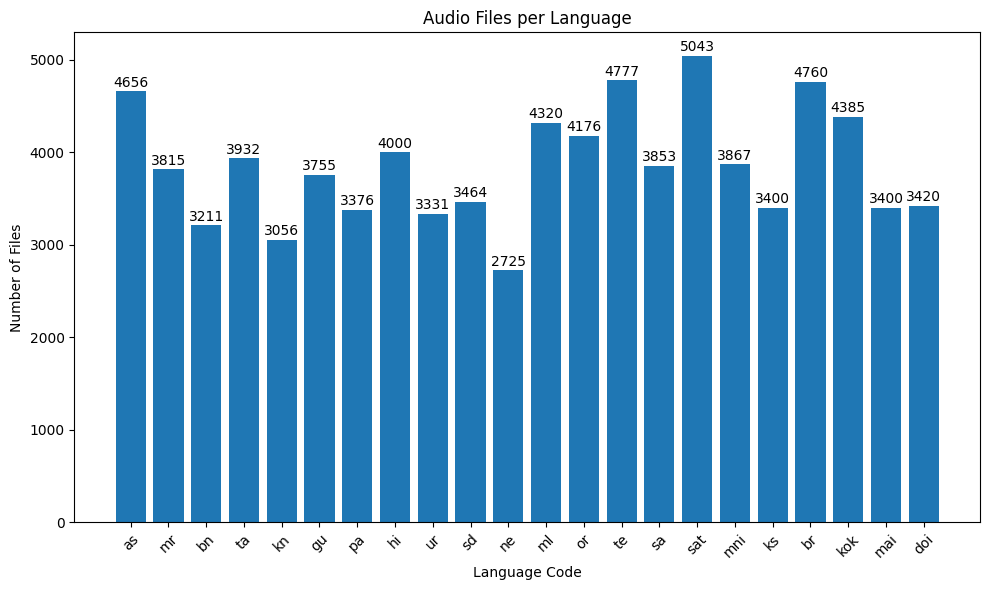

In [4]:
def load_audio_data(base_folder):
    """
    Load audio files from target language folders
    """
    print(f"📁 Scanning folder: {base_folder}")

    all_files = []
    all_labels = []
    language_stats = {}

    for lang_code in CONFIG['target_folders']:
        lang_folder = os.path.join(base_folder, lang_code)

        if not os.path.exists(lang_folder):
            print(f"⚠️ Warning: Folder {lang_folder} not found!")
            continue

        # Find all audio files
        audio_files = []
        for ext in CONFIG['audio_extensions']:
            pattern = os.path.join(lang_folder, '**', f'*{ext}')
            audio_files.extend(glob.glob(pattern, recursive=True))
            # Also check uppercase
            pattern_upper = os.path.join(lang_folder, '**', f'*{ext.upper()}')
            audio_files.extend(glob.glob(pattern_upper, recursive=True))

        if not audio_files:
            print(f"⚠️ No audio files found in {lang_folder}")
            continue

        print(f"✅ Found {len(audio_files)} files for {lang_code} ({TARGET_LANGUAGES[lang_code]})")

        # Add to dataset
        label_id = LANG_TO_ID[lang_code]
        for audio_file in audio_files:
            all_files.append(audio_file)
            all_labels.append(label_id)

        language_stats[lang_code] = len(audio_files)

    print(f"\n📊 Dataset Summary:")
    print(f"Total files: {len(all_files)}")
    print(f"Languages: {len(language_stats)}")

    # Plot distribution
    plt.figure(figsize=(10, 6))
    languages = list(language_stats.keys())
    counts = list(language_stats.values())

    plt.bar(languages, counts)
    plt.title('Audio Files per Language')
    plt.xlabel('Language Code')
    plt.ylabel('Number of Files')
    plt.xticks(rotation=45)

    for i, count in enumerate(counts):
        plt.text(i, count + max(counts)*0.01, str(count), ha='center')

    plt.tight_layout()
    plt.show()

    return all_files, all_labels, language_stats

# Update this path to your data folder in Google Drive
DATA_FOLDER = "/home/aic_u2/aic_u2/NoumidaA/Data/23 languages/"

# Load data (comment out if you want to set the path manually)
all_files, all_labels, stats = load_audio_data(DATA_FOLDER)
# print("📝 Please update DATA_FOLDER path above and uncomment the load_audio_data line")

In [5]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class AudioLanguageDataset(Dataset):
    """Custom dataset for audio language identification"""

    def __init__(self, audio_files, labels, transform=None):
        self.audio_files = audio_files
        self.labels = labels
        self.transform = transform
        self.sample_rate = CONFIG['sample_rate']
        self.max_duration = CONFIG['max_duration']

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_path = self.audio_files[idx]
        label = self.labels[idx]

        try:
            # Load audio
            waveform = self._load_audio(audio_path)

            if waveform is None:
                # Return zeros if loading fails
                waveform = torch.zeros(int(self.sample_rate * 5))

            return {
                'input_values': waveform,
                'labels': torch.tensor(label, dtype=torch.long),
                'audio_path': audio_path
            }
        except Exception as e:
            print(f"Error loading {audio_path}: {e}")
            waveform = torch.zeros(int(self.sample_rate * 5))
            return {
                'input_values': waveform,
                'labels': torch.tensor(label, dtype=torch.long),
                'audio_path': audio_path
            }

    def _load_audio(self, audio_path):
        """Load and preprocess audio"""
        try:
            # Load with librosa
            waveform, sr = librosa.load(
                audio_path,
                sr=self.sample_rate,
                mono=True
            )

            # Check duration
            duration = len(waveform) / self.sample_rate

            if duration < CONFIG['min_duration']:
                # Pad if too short
                target_length = int(CONFIG['min_duration'] * self.sample_rate)
                if len(waveform) < target_length:
                    waveform = np.pad(waveform, (0, target_length - len(waveform)), mode='constant')

            elif duration > self.max_duration:
                # Truncate if too long
                max_length = int(self.max_duration * self.sample_rate)
                waveform = waveform[:max_length]

            # Convert to tensor and normalize
            waveform = torch.FloatTensor(waveform)
            if waveform.abs().max() > 0:
                waveform = waveform / waveform.abs().max()

            return waveform

        except Exception as e:
            print(f"Failed to load {audio_path}: {e}")
            return None

def create_datasets(all_files, all_labels):
    """Create train/val/test splits"""

    # Stratified split
    X_train, X_temp, y_train, y_temp = train_test_split(
        all_files, all_labels,
        test_size=(1 - CONFIG['train_split']),
        random_state=42,
        stratify=all_labels
    )

    # Split temp into val and test
    val_ratio = CONFIG['val_split'] / (CONFIG['val_split'] + CONFIG['test_split'])
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=(1 - val_ratio),
        random_state=42,
        stratify=y_temp
    )

    # Create datasets
    train_dataset = AudioLanguageDataset(X_train, y_train)
    val_dataset = AudioLanguageDataset(X_val, y_val)
    test_dataset = AudioLanguageDataset(X_test, y_test)

    print(f"📊 Dataset Splits:")
    print(f"  Train: {len(train_dataset)} samples")
    print(f"  Validation: {len(val_dataset)} samples")
    print(f"  Test: {len(test_dataset)} samples")

    return train_dataset, val_dataset, test_dataset

# Create datasets (uncomment when you have loaded the data)
train_dataset, val_dataset, test_dataset = create_datasets(all_files, all_labels)
# print("📝 Uncomment the create_datasets line above after loading data")


📊 Dataset Splits:
  Train: 67777 samples
  Validation: 8472 samples
  Test: 8473 samples


In [8]:
from transformers import (
    Wav2Vec2Model,
    Wav2Vec2FeatureExtractor,
    AutoModel,
    AutoFeatureExtractor
)

class CustomMMS_LID(nn.Module):
    """Custom MMS-LID model with new classification head"""

    def __init__(self, base_model_name, num_classes=7, freeze_base=False):
        super(CustomMMS_LID, self).__init__()

        self.num_classes = num_classes
        self.freeze_base = freeze_base

        print(f"🤖 Loading base model: {base_model_name}")

        # Load base model
        try:
            self.feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(base_model_name)
            self.base_model = Wav2Vec2Model.from_pretrained(base_model_name)
            print("✅ Loaded as Wav2Vec2 model")
        except Exception as e:
            print(f"Wav2Vec2 loading failed, trying AutoModel: {e}")
            self.feature_extractor = AutoFeatureExtractor.from_pretrained(base_model_name)
            self.base_model = AutoModel.from_pretrained(base_model_name)
            print("✅ Loaded as AutoModel")

        # Get hidden size
        hidden_size = getattr(self.base_model.config, 'hidden_size', 768)
        print(f"📏 Hidden size: {hidden_size}")

        if freeze_base:
            for param in self.base_model.parameters():
                param.requires_grad = False
            print("🔒 Base model frozen")

        # Create new classification head
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size, num_classes)

        # Initialize weights
        nn.init.normal_(self.classifier.weight, mean=0.0, std=0.02)
        nn.init.zeros_(self.classifier.bias)

        print(f"✅ Classification head: {hidden_size} -> {num_classes}")

    def forward(self, input_values, attention_mask=None):
        """Forward pass"""
        # Get base model outputs
        outputs = self.base_model(
            input_values=input_values,
            attention_mask=attention_mask,
            output_hidden_states=True
        )

        # Global average pooling
        hidden_states = outputs.last_hidden_state
        pooled_output = torch.mean(hidden_states, dim=1)

        # Classification
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return {'logits': logits, 'hidden_states': hidden_states}

    def predict(self, waveform, sampling_rate=16000):
        """Make prediction on audio"""
        self.eval()

        with torch.no_grad():
            # Preprocess
            if isinstance(waveform, torch.Tensor):
                waveform_np = waveform.cpu().numpy()
            else:
                waveform_np = waveform

            inputs = self.feature_extractor(
                waveform_np,
                sampling_rate=sampling_rate,
                return_tensors="pt",
                padding=True
            )

            input_values = inputs['input_values'].to(next(self.parameters()).device)

            # Forward pass
            outputs = self.forward(input_values)
            logits = outputs['logits']

            # Get probabilities
            probs = torch.softmax(logits, dim=-1)
            pred_id = torch.argmax(probs, dim=-1).item()
            confidence = probs[0, pred_id].item()

            # Top predictions
            top_probs, top_indices = torch.topk(probs, k=min(3, self.num_classes))

            predictions = []
            for i in range(len(top_indices[0])):
                idx = top_indices[0][i].item()
                prob = top_probs[0][i].item()
                lang_code = list(TARGET_LANGUAGES.keys())[idx]
                lang_name = TARGET_LANGUAGES[lang_code]

                predictions.append({
                    'language_code': lang_code,
                    'language_name': lang_name,
                    'confidence': prob
                })

            return {
                'predicted_language': list(TARGET_LANGUAGES.keys())[pred_id],
                'confidence': confidence,
                'all_predictions': predictions
            }

# Create model
model = CustomMMS_LID(
    base_model_name=CONFIG['base_model'],
    num_classes=CONFIG['num_classes'],
    freeze_base=True  # Set to True to only train classification head
).to(device)

print(f"✅ Model created and moved to {device}")


🤖 Loading base model: facebook/mms-lid-126
✅ Loaded as Wav2Vec2 model
📏 Hidden size: 1280
🔒 Base model frozen
✅ Classification head: 1280 -> 22
✅ Model created and moved to cuda


In [9]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR, StepLR
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

def collate_fn(batch):
    """Custom collate function for variable length audio"""
    input_values = []
    labels = []

    # Find max length
    max_length = max([item['input_values'].shape[0] for item in batch])

    for item in batch:
        audio = item['input_values']
        label = item['labels']

        # Pad to max length
        if audio.shape[0] < max_length:
            padding = max_length - audio.shape[0]
            audio = torch.cat([audio, torch.zeros(padding)])

        input_values.append(audio)
        labels.append(label)

    return {
        'input_values': torch.stack(input_values),
        'labels': torch.stack(labels)
    }

def train_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc="Training")

    for batch_idx, batch in enumerate(progress_bar):
        # Move to device
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_values)
        loss = criterion(outputs['logits'], labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Step scheduler per batch for OneCycleLR
        if isinstance(scheduler, OneCycleLR):
            scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

    # Step scheduler per epoch for other schedulers
    if not isinstance(scheduler, OneCycleLR):
        scheduler.step()

    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_values = batch['input_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_values)
            loss = criterion(outputs['logits'], labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs['logits'], dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy, all_preds, all_labels

# Setup training components (uncomment after datasets are ready)

from torch.utils.data import DataLoader


train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True
)

# Optimizer
optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])

# Learning rate scheduler options:
total_steps = len(train_loader) * CONFIG['num_epochs']

# Option 1: OneCycleLR (recommended)
scheduler = OneCycleLR(
    optimizer,
    max_lr=CONFIG['learning_rate'],
    total_steps=total_steps,
    pct_start=CONFIG['warmup_ratio']
)

# Option 2: CosineAnnealingLR
# scheduler = CosineAnnealingLR(optimizer, T_max=CONFIG['num_epochs'])

# Option 3: StepLR
# scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

# Loss function
criterion = nn.CrossEntropyLoss()

print("✅ Training components ready with PyTorch schedulers")
print(f"📊 Training batches: {len(train_loader)}")
print(f"📊 Validation batches: {len(val_loader)}")
print(f"⚙️ Total training steps: {total_steps}")
print(f"🔥 Using scheduler: {type(scheduler).__name__}")


# print("📝 Uncomment the training setup code above after datasets are ready")


✅ Training components ready with PyTorch schedulers
📊 Training batches: 8473
📊 Validation batches: 1059
⚙️ Total training steps: 847300
🔥 Using scheduler: OneCycleLR


In [ ]:
# Main training function
def train_model():
    """Main training loop"""
    print("🚀 Starting training...")

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    best_accuracy = 0
    patience_counter = 0
    patience = 3

    for epoch in range(CONFIG['num_epochs']):
        print(f"\n📍 Epoch {epoch+1}/{CONFIG['num_epochs']}")
        print("-" * 50)

        # Train
        train_loss = train_epoch(model, train_loader, optimizer, scheduler, criterion, device)

        # Validate
        val_loss, val_accuracy, val_preds, val_labels = validate(model, val_loader, criterion, device)

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        # Print metrics
        current_lr = scheduler.get_last_lr()[0]
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy: {val_accuracy:.4f}")
        print(f"Learning Rate: {current_lr:.2e}")

        # Save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': val_accuracy,
                'epoch': epoch,
                'config': CONFIG
            }, '/home/aic_u2/aic_u2/NoumidaA/Notebooks/model_freeze_22_new.pt')
            patience_counter = 0
            print(f"✅ New best model saved! Accuracy: {val_accuracy:.4f}")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"⏹️ Early stopping triggered after {epoch+1} epochs")
            break

    print(f"\n🎉 Training completed!")
    print(f"Best validation accuracy: {best_accuracy:.4f}")

    return history


history = train_model()


🚀 Starting training...

📍 Epoch 1/100
--------------------------------------------------


Training:   0%|          | 0/8473 [00:00<?, ?it/s]

Training: 100%|██████████| 8473/8473 [2:23:52<00:00,  1.02s/it, Loss=2.0622]  


Train Loss: 2.8680
Val Loss: 2.3634
Val Accuracy: 0.5208
Learning Rate: 1.90e-06
✅ New best model saved! Accuracy: 0.5208

📍 Epoch 2/100
--------------------------------------------------


Training: 100%|██████████| 8473/8473 [1:58:13<00:00,  1.19it/s, Loss=0.7214]  


Train Loss: 2.1282
Val Loss: 1.4849
Val Accuracy: 0.6261
Learning Rate: 3.95e-06
✅ New best model saved! Accuracy: 0.6261

📍 Epoch 3/100
--------------------------------------------------


Training: 100%|██████████| 8473/8473 [2:16:39<00:00,  1.03it/s, Loss=0.2380]  


Train Loss: 1.5489
Val Loss: 1.0923
Val Accuracy: 0.6701
Learning Rate: 7.14e-06
✅ New best model saved! Accuracy: 0.6701

📍 Epoch 4/100
--------------------------------------------------


Training: 100%|██████████| 8473/8473 [1:54:59<00:00,  1.23it/s, Loss=0.9437]  


Train Loss: 1.2937
Val Loss: 0.9638
Val Accuracy: 0.6970
Learning Rate: 1.12e-05
✅ New best model saved! Accuracy: 0.6970

📍 Epoch 5/100
--------------------------------------------------


Training: 100%|██████████| 8473/8473 [1:54:55<00:00,  1.23it/s, Loss=0.0447]  


Train Loss: 1.1779
Val Loss: 0.9117
Val Accuracy: 0.7100
Learning Rate: 1.56e-05
✅ New best model saved! Accuracy: 0.7100

📍 Epoch 6/100
--------------------------------------------------


Training: 100%|██████████| 8473/8473 [1:54:52<00:00,  1.23it/s, Loss=2.5821]  


Train Loss: 1.1218
Val Loss: 0.8762
Val Accuracy: 0.7210
Learning Rate: 2.01e-05
✅ New best model saved! Accuracy: 0.7210

📍 Epoch 7/100
--------------------------------------------------


Training: 100%|██████████| 8473/8473 [1:55:01<00:00,  1.23it/s, Loss=0.1192]  


Train Loss: 1.0806
Val Loss: 0.8550
Val Accuracy: 0.7269
Learning Rate: 2.41e-05
✅ New best model saved! Accuracy: 0.7269

📍 Epoch 8/100
--------------------------------------------------


Training: 100%|██████████| 8473/8473 [1:54:50<00:00,  1.23it/s, Loss=0.0014]  


Train Loss: 1.0481
Val Loss: 0.8397
Val Accuracy: 0.7321
Learning Rate: 2.73e-05
✅ New best model saved! Accuracy: 0.7321

📍 Epoch 9/100
--------------------------------------------------


Training: 100%|██████████| 8473/8473 [1:54:26<00:00,  1.23it/s, Loss=0.0066]  


Train Loss: 1.0231
Val Loss: 0.8301
Val Accuracy: 0.7329
Learning Rate: 2.93e-05
✅ New best model saved! Accuracy: 0.7329

📍 Epoch 10/100
--------------------------------------------------


Training: 100%|██████████| 8473/8473 [1:54:34<00:00,  1.23it/s, Loss=0.1617]  


Train Loss: 1.0077
Val Loss: 0.8103
Val Accuracy: 0.7419
Learning Rate: 3.00e-05
✅ New best model saved! Accuracy: 0.7419

📍 Epoch 11/100
--------------------------------------------------


Training: 100%|██████████| 8473/8473 [1:54:34<00:00,  1.23it/s, Loss=3.3083]  


Train Loss: 0.9900
Val Loss: 0.8087
Val Accuracy: 0.7422
Learning Rate: 3.00e-05
✅ New best model saved! Accuracy: 0.7422

📍 Epoch 12/100
--------------------------------------------------


Training: 100%|██████████| 8473/8473 [1:54:32<00:00,  1.23it/s, Loss=1.6141]  


Train Loss: 0.9806
Val Loss: 0.7958
Val Accuracy: 0.7467
Learning Rate: 3.00e-05
✅ New best model saved! Accuracy: 0.7467

📍 Epoch 13/100
--------------------------------------------------


Training:  46%|████▌     | 3874/8473 [52:38<1:05:20,  1.17it/s, Loss=2.0245]

📊 Final Evaluation


Validating:   0%|          | 0/1060 [00:00<?, ?it/s]

🎯 Test Accuracy: 0.7447

📈 Classification Report:
                precision    recall  f1-score   support

 as (Assamese)       0.97      0.98      0.97       466
  mr (Marathi)       0.58      0.74      0.65       381
  bn (Bengali)       0.83      0.85      0.84       321
    ta (Tamil)       0.93      0.86      0.89       394
  kn (Kannada)       0.88      0.88      0.88       305
 gu (Gujarati)       0.74      0.73      0.73       375
  pa (Punjabi)       0.57      0.77      0.65       337
    hi (Hindi)       0.59      0.53      0.56       400
     ur (Urdu)       0.74      0.70      0.72       333
   sd (Sindhi)       0.92      0.96      0.94       346
   ne (Nepali)       0.78      0.88      0.83       272
ml (Malayalam)       0.80      0.85      0.82       432
     or (Odia)       0.74      0.68      0.71       418
   te (Telugu)       0.71      0.81      0.76       478
 sa (Sanskrit)       0.67      0.85      0.75       386
 sat (Santali)       0.81      0.64      0.71       5

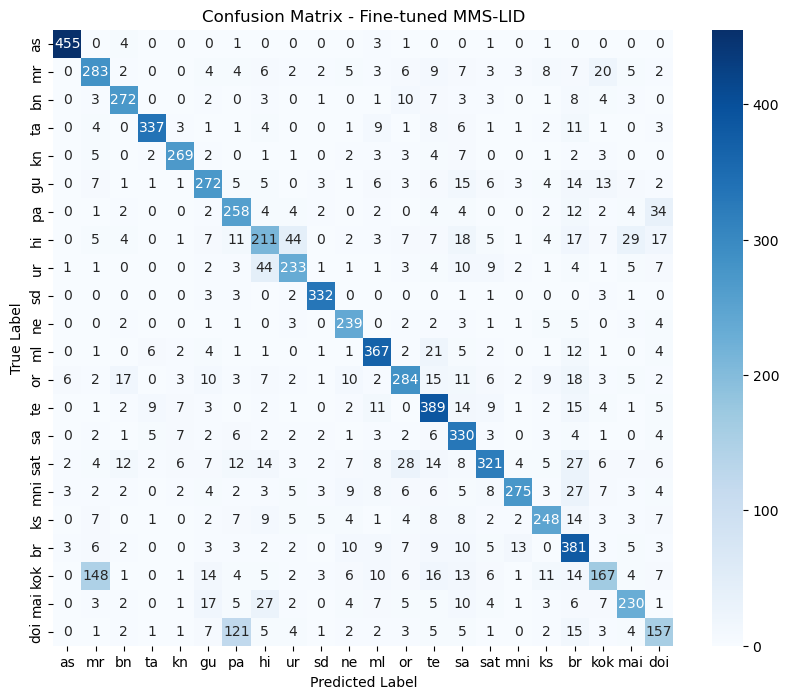


📊 Per-class Accuracy:
  as (Assamese): 0.976
  mr (Marathi): 0.743
  bn (Bengali): 0.847
  ta (Tamil): 0.855
  kn (Kannada): 0.882
  gu (Gujarati): 0.725
  pa (Punjabi): 0.766
  hi (Hindi): 0.527
  ur (Urdu): 0.700
  sd (Sindhi): 0.960
  ne (Nepali): 0.879
  ml (Malayalam): 0.850
  or (Odia): 0.679
  te (Telugu): 0.814
  sa (Sanskrit): 0.855
  sat (Santali): 0.636
  mni (Manipuri): 0.711
  ks (Kashmiri): 0.729
  br (Bodo): 0.800
  kok (Konkani): 0.380
  mai (Maithili): 0.676
  doi (Dogri): 0.459


In [12]:
# def plot_training_history(history):
#     """Plot training history"""
#     fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#     # Loss
#     axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
#     axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
#     axes[0].set_title('Training and Validation Loss')
#     axes[0].set_xlabel('Epoch')
#     axes[0].set_ylabel('Loss')
#     axes[0].legend()
#     axes[0].grid(True, alpha=0.3)

#     # Accuracy
#     axes[1].plot(history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
#     axes[1].set_title('Validation Accuracy')
#     axes[1].set_xlabel('Epoch')
#     axes[1].set_ylabel('Accuracy')
#     axes[1].legend()
#     axes[1].grid(True, alpha=0.3)

#     # Best accuracy line
#     best_acc = max(history['val_accuracy'])
#     best_epoch = history['val_accuracy'].index(best_acc)
#     axes[1].axhline(y=best_acc, color='red', linestyle='--', alpha=0.7,
#                     label=f'Best: {best_acc:.3f} (Epoch {best_epoch+1})')
#     axes[1].legend()

#     # Combined plot
#     ax2 = axes[2].twinx()

#     line1 = axes[2].plot(history['train_loss'], 'b-', marker='o', label='Train Loss', alpha=0.7)
#     line2 = axes[2].plot(history['val_loss'], 'r-', marker='s', label='Val Loss', alpha=0.7)
#     line3 = ax2.plot(history['val_accuracy'], 'g-', marker='^', label='Val Accuracy', alpha=0.7)

#     axes[2].set_xlabel('Epoch')
#     axes[2].set_ylabel('Loss', color='black')
#     ax2.set_ylabel('Accuracy', color='green')

#     # Combine legends
#     lines1 = line1 + line2
#     lines2 = line3
#     labels1 = [l.get_label() for l in lines1]
#     labels2 = [l.get_label() for l in lines2]
#     axes[2].legend(lines1 + lines2, labels1 + labels2, loc='center right')

#     axes[2].set_title('Training Overview')
#     axes[2].grid(True, alpha=0.3)

#     plt.tight_layout()
#     plt.show()

def final_evaluation():
    """Perform final evaluation"""
    print("📊 Final Evaluation")
    print("=" * 50)

    # Load best model
    checkpoint = torch.load('/NoumidaA/Notebooks/model_freeze_22b.pt', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Validate on test set
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, collate_fn=collate_fn)

    _, test_accuracy, test_preds, test_labels = validate(model, test_loader, criterion, device)

    print(f"🎯 Test Accuracy: {test_accuracy:.4f}")

    # Classification report
    target_names = [f"{code} ({TARGET_LANGUAGES[code]})" for code in TARGET_LANGUAGES.keys()]
    report = classification_report(test_labels, test_preds, target_names=target_names)
    print(f"\n📈 Classification Report:")
    print(report)

    # Confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(test_labels, test_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=list(TARGET_LANGUAGES.keys()),
               yticklabels=list(TARGET_LANGUAGES.keys()))
    plt.title('Confusion Matrix - Fine-tuned MMS-LID')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Per-class accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    print(f"\n📊 Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        lang_code = list(TARGET_LANGUAGES.keys())[i]
        lang_name = TARGET_LANGUAGES[lang_code]
        print(f"  {lang_code} ({lang_name}): {acc:.3f}")

# Uncomment after training
# plot_training_history(history)
final_evaluation()


📊 Final Evaluation


Validating:   0%|          | 0/798 [00:00<?, ?it/s]

🎯 Test Accuracy: 0.7401

📈 Classification Report:
                precision    recall  f1-score   support

 as (Assamese)       0.90      0.96      0.93       465
  mr (Marathi)       0.59      0.70      0.64       382
  en (English)       0.00      0.00      0.00         4
  bn (Bengali)       0.78      0.84      0.81       321
    ta (Tamil)       0.95      0.84      0.89       394
  kn (Kannada)       0.86      0.86      0.86       305
   sd (Sindhi)       0.85      0.91      0.88       347
ml (Malayalam)       0.78      0.85      0.81       432
     or (Odia)       0.78      0.67      0.72       417
   te (Telugu)       0.69      0.80      0.74       478
 sa (Sanskrit)       0.00      0.00      0.00        10
 sat (Santali)       0.66      0.57      0.61       504
mni (Manipuri)       0.81      0.74      0.77       387
 ks (Kashmiri)       0.68      0.68      0.68       340
     br (Bodo)       0.64      0.71      0.67       476
 kok (Konkani)       0.49      0.34      0.40       4

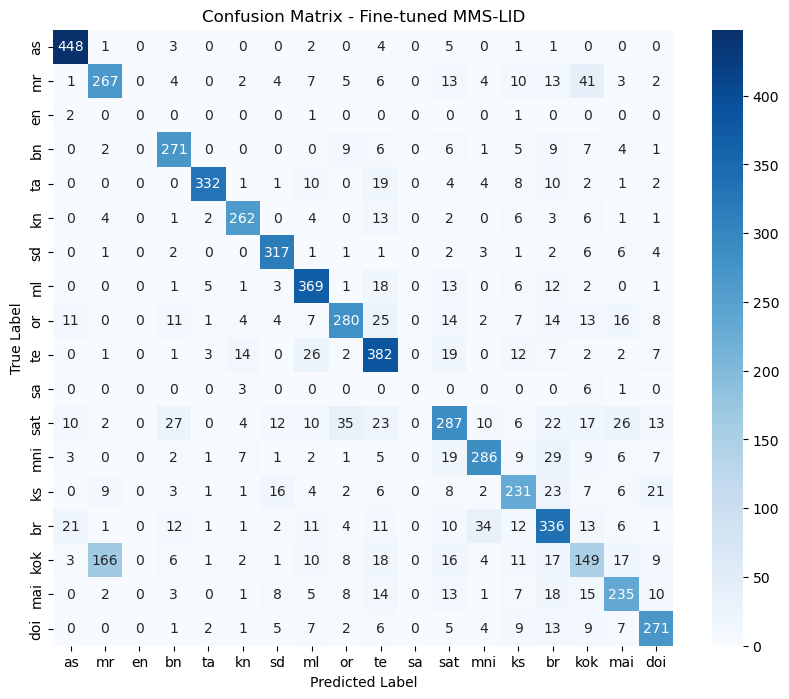


📊 Per-class Accuracy:
  as (Assamese): 0.963
  mr (Marathi): 0.699
  en (English): 0.000
  bn (Bengali): 0.844
  ta (Tamil): 0.843
  kn (Kannada): 0.859
  sd (Sindhi): 0.914
  ml (Malayalam): 0.854
  or (Odia): 0.671
  te (Telugu): 0.799
  sa (Sanskrit): 0.000
  sat (Santali): 0.569
  mni (Manipuri): 0.739
  ks (Kashmiri): 0.679
  br (Bodo): 0.706
  kok (Konkani): 0.340
  mai (Maithili): 0.691
  doi (Dogri): 0.792


In [14]:
# def plot_training_history(history):
#     """Plot training history"""
#     fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#     # Loss
#     axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
#     axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
#     axes[0].set_title('Training and Validation Loss')
#     axes[0].set_xlabel('Epoch')
#     axes[0].set_ylabel('Loss')
#     axes[0].legend()
#     axes[0].grid(True, alpha=0.3)

#     # Accuracy
#     axes[1].plot(history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
#     axes[1].set_title('Validation Accuracy')
#     axes[1].set_xlabel('Epoch')
#     axes[1].set_ylabel('Accuracy')
#     axes[1].legend()
#     axes[1].grid(True, alpha=0.3)

#     # Best accuracy line
#     best_acc = max(history['val_accuracy'])
#     best_epoch = history['val_accuracy'].index(best_acc)
#     axes[1].axhline(y=best_acc, color='red', linestyle='--', alpha=0.7,
#                     label=f'Best: {best_acc:.3f} (Epoch {best_epoch+1})')
#     axes[1].legend()

#     # Combined plot
#     ax2 = axes[2].twinx()

#     line1 = axes[2].plot(history['train_loss'], 'b-', marker='o', label='Train Loss', alpha=0.7)
#     line2 = axes[2].plot(history['val_loss'], 'r-', marker='s', label='Val Loss', alpha=0.7)
#     line3 = ax2.plot(history['val_accuracy'], 'g-', marker='^', label='Val Accuracy', alpha=0.7)

#     axes[2].set_xlabel('Epoch')
#     axes[2].set_ylabel('Loss', color='black')
#     ax2.set_ylabel('Accuracy', color='green')

#     # Combine legends
#     lines1 = line1 + line2
#     lines2 = line3
#     labels1 = [l.get_label() for l in lines1]
#     labels2 = [l.get_label() for l in lines2]
#     axes[2].legend(lines1 + lines2, labels1 + labels2, loc='center right')

#     axes[2].set_title('Training Overview')
#     axes[2].grid(True, alpha=0.3)

#     plt.tight_layout()
#     plt.show()

def final_evaluation():
    """Perform final evaluation"""
    print("📊 Final Evaluation")
    print("=" * 50)

    # Load best model
    checkpoint = torch.load('/NoumidaA/Notebooks/model_freeze_23.pt', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Validate on test set
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, collate_fn=collate_fn)

    _, test_accuracy, test_preds, test_labels = validate(model, test_loader, criterion, device)

    print(f"🎯 Test Accuracy: {test_accuracy:.4f}")

    # Classification report
    target_names = [f"{code} ({TARGET_LANGUAGES[code]})" for code in TARGET_LANGUAGES.keys()]
    report = classification_report(test_labels, test_preds, target_names=target_names)
    print(f"\n📈 Classification Report:")
    print(report)

    # Confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(test_labels, test_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=list(TARGET_LANGUAGES.keys()),
               yticklabels=list(TARGET_LANGUAGES.keys()))
    plt.title('Confusion Matrix - Fine-tuned MMS-LID')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Per-class accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    print(f"\n📊 Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        lang_code = list(TARGET_LANGUAGES.keys())[i]
        lang_name = TARGET_LANGUAGES[lang_code]
        print(f"  {lang_code} ({lang_name}): {acc:.3f}")

# Uncomment after training
# plot_training_history(history)
final_evaluation()


📊 Final Evaluation


Validating:   0%|          | 0/520 [00:00<?, ?it/s]

🎯 Test Accuracy: 0.8288

📈 Classification Report:
                precision    recall  f1-score   support

 as (Assamese)       0.96      0.98      0.97       466
  mr (Marathi)       0.00      0.00      0.00        12
  en (English)       1.00      1.00      1.00         3
  bn (Bengali)       0.87      0.99      0.93       112
    ta (Tamil)       0.86      1.00      0.92        18
  kn (Kannada)       0.90      0.89      0.89       306
  pa (Punjabi)       0.00      0.00      0.00         6
    hi (Hindi)       0.00      0.00      0.00         7
     ur (Urdu)       0.00      0.00      0.00         1
   sd (Sindhi)       0.92      0.96      0.94       347
   ne (Nepali)       0.00      0.00      0.00         3
ml (Malayalam)       1.00      0.33      0.50         3
     or (Odia)       0.81      0.68      0.74        19
   te (Telugu)       1.00      0.75      0.86        12
 sa (Sanskrit)       1.00      1.00      1.00        10
 sat (Santali)       0.84      0.72      0.78       5

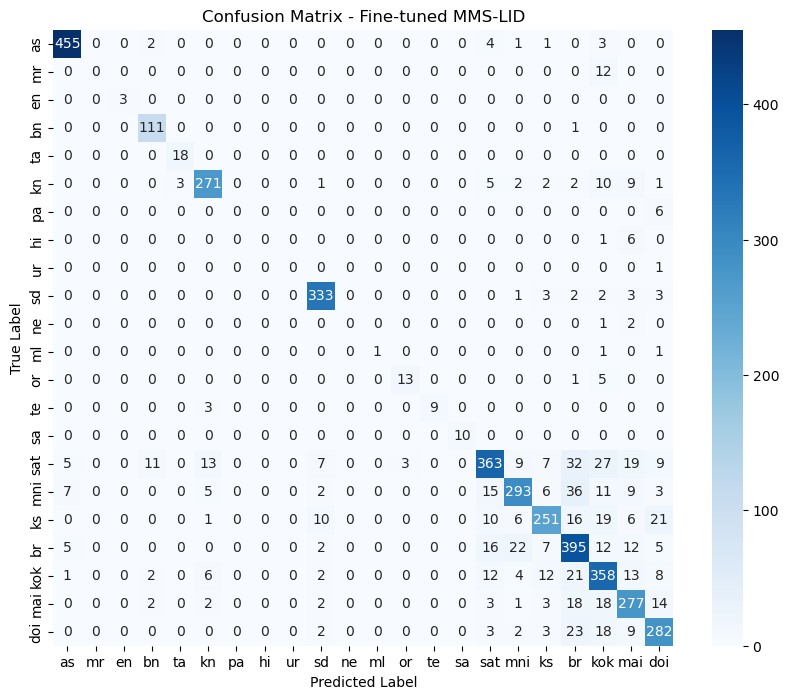


📊 Per-class Accuracy:
  as (Assamese): 0.976
  mr (Marathi): 0.000
  en (English): 1.000
  bn (Bengali): 0.991
  ta (Tamil): 1.000
  kn (Kannada): 0.886
  pa (Punjabi): 0.000
  hi (Hindi): 0.000
  ur (Urdu): 0.000
  sd (Sindhi): 0.960
  ne (Nepali): 0.000
  ml (Malayalam): 0.333
  or (Odia): 0.684
  te (Telugu): 0.750
  sa (Sanskrit): 1.000
  sat (Santali): 0.719
  mni (Manipuri): 0.757
  ks (Kashmiri): 0.738
  br (Bodo): 0.830
  kok (Konkani): 0.815
  mai (Maithili): 0.815
  doi (Dogri): 0.825


In [15]:
# def plot_training_history(history):
#     """Plot training history"""
#     fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#     # Loss
#     axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
#     axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
#     axes[0].set_title('Training and Validation Loss')
#     axes[0].set_xlabel('Epoch')
#     axes[0].set_ylabel('Loss')
#     axes[0].legend()
#     axes[0].grid(True, alpha=0.3)

#     # Accuracy
#     axes[1].plot(history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
#     axes[1].set_title('Validation Accuracy')
#     axes[1].set_xlabel('Epoch')
#     axes[1].set_ylabel('Accuracy')
#     axes[1].legend()
#     axes[1].grid(True, alpha=0.3)

#     # Best accuracy line
#     best_acc = max(history['val_accuracy'])
#     best_epoch = history['val_accuracy'].index(best_acc)
#     axes[1].axhline(y=best_acc, color='red', linestyle='--', alpha=0.7,
#                     label=f'Best: {best_acc:.3f} (Epoch {best_epoch+1})')
#     axes[1].legend()

#     # Combined plot
#     ax2 = axes[2].twinx()

#     line1 = axes[2].plot(history['train_loss'], 'b-', marker='o', label='Train Loss', alpha=0.7)
#     line2 = axes[2].plot(history['val_loss'], 'r-', marker='s', label='Val Loss', alpha=0.7)
#     line3 = ax2.plot(history['val_accuracy'], 'g-', marker='^', label='Val Accuracy', alpha=0.7)

#     axes[2].set_xlabel('Epoch')
#     axes[2].set_ylabel('Loss', color='black')
#     ax2.set_ylabel('Accuracy', color='green')

#     # Combine legends
#     lines1 = line1 + line2
#     lines2 = line3
#     labels1 = [l.get_label() for l in lines1]
#     labels2 = [l.get_label() for l in lines2]
#     axes[2].legend(lines1 + lines2, labels1 + labels2, loc='center right')

#     axes[2].set_title('Training Overview')
#     axes[2].grid(True, alpha=0.3)

#     plt.tight_layout()
#     plt.show()

def final_evaluation():
    """Perform final evaluation"""
    print("📊 Final Evaluation")
    print("=" * 50)

    # Load best model
    checkpoint = torch.load('/NoumidaA/Notebooks/model_freeze_23.pt', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Validate on test set
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, collate_fn=collate_fn)

    _, test_accuracy, test_preds, test_labels = validate(model, test_loader, criterion, device)

    print(f"🎯 Test Accuracy: {test_accuracy:.4f}")

    # Classification report
    target_names = [f"{code} ({TARGET_LANGUAGES[code]})" for code in TARGET_LANGUAGES.keys()]
    report = classification_report(test_labels, test_preds, target_names=target_names)
    print(f"\n📈 Classification Report:")
    print(report)

    # Confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(test_labels, test_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=list(TARGET_LANGUAGES.keys()),
               yticklabels=list(TARGET_LANGUAGES.keys()))
    plt.title('Confusion Matrix - Fine-tuned MMS-LID')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Per-class accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    print(f"\n📊 Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        lang_code = list(TARGET_LANGUAGES.keys())[i]
        lang_name = TARGET_LANGUAGES[lang_code]
        print(f"  {lang_code} ({lang_name}): {acc:.3f}")

# Uncomment after training
# plot_training_history(history)
final_evaluation()


📊 Final Evaluation


Validating:   0%|          | 0/354 [00:00<?, ?it/s]

🎯 Test Accuracy: 0.8168

📈 Classification Report:
                precision    recall  f1-score   support

 sat (Santali)       0.83      0.82      0.83       505
mni (Manipuri)       0.89      0.78      0.83       386
 ks (Kashmiri)       0.82      0.81      0.82       340
     br (Bodo)       0.80      0.83      0.81       476
 kok (Konkani)       0.80      0.80      0.80       439
mai (Maithili)       0.78      0.83      0.81       340
   doi (Dogri)       0.81      0.84      0.82       342

      accuracy                           0.82      2828
     macro avg       0.82      0.82      0.82      2828
  weighted avg       0.82      0.82      0.82      2828



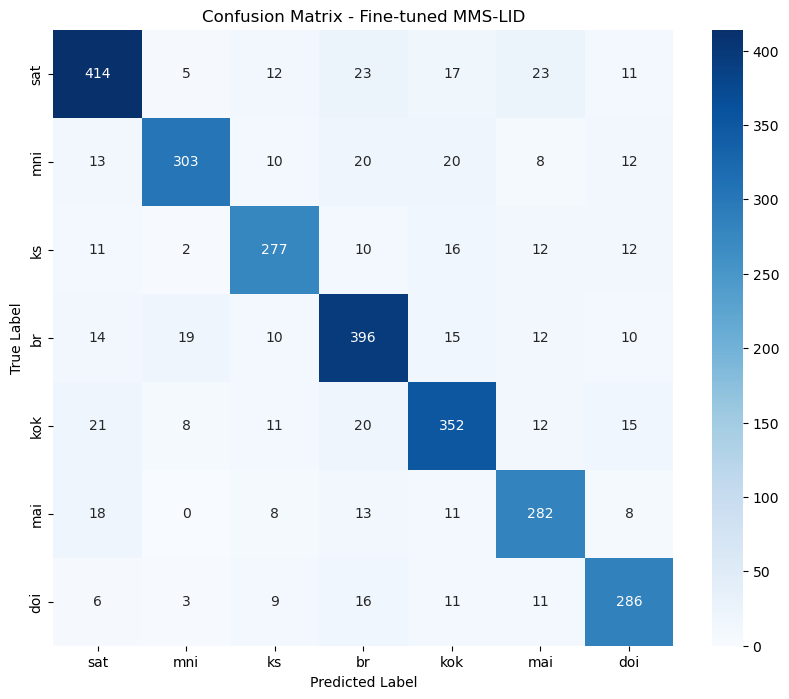


📊 Per-class Accuracy:
  sat (Santali): 0.820
  mni (Manipuri): 0.785
  ks (Kashmiri): 0.815
  br (Bodo): 0.832
  kok (Konkani): 0.802
  mai (Maithili): 0.829
  doi (Dogri): 0.836


In [19]:
# def plot_training_history(history):
#     """Plot training history"""
#     fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#     # Loss
#     axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
#     axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
#     axes[0].set_title('Training and Validation Loss')
#     axes[0].set_xlabel('Epoch')
#     axes[0].set_ylabel('Loss')
#     axes[0].legend()
#     axes[0].grid(True, alpha=0.3)

#     # Accuracy
#     axes[1].plot(history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
#     axes[1].set_title('Validation Accuracy')
#     axes[1].set_xlabel('Epoch')
#     axes[1].set_ylabel('Accuracy')
#     axes[1].legend()
#     axes[1].grid(True, alpha=0.3)

#     # Best accuracy line
#     best_acc = max(history['val_accuracy'])
#     best_epoch = history['val_accuracy'].index(best_acc)
#     axes[1].axhline(y=best_acc, color='red', linestyle='--', alpha=0.7,
#                     label=f'Best: {best_acc:.3f} (Epoch {best_epoch+1})')
#     axes[1].legend()

#     # Combined plot
#     ax2 = axes[2].twinx()

#     line1 = axes[2].plot(history['train_loss'], 'b-', marker='o', label='Train Loss', alpha=0.7)
#     line2 = axes[2].plot(history['val_loss'], 'r-', marker='s', label='Val Loss', alpha=0.7)
#     line3 = ax2.plot(history['val_accuracy'], 'g-', marker='^', label='Val Accuracy', alpha=0.7)

#     axes[2].set_xlabel('Epoch')
#     axes[2].set_ylabel('Loss', color='black')
#     ax2.set_ylabel('Accuracy', color='green')

#     # Combine legends
#     lines1 = line1 + line2
#     lines2 = line3
#     labels1 = [l.get_label() for l in lines1]
#     labels2 = [l.get_label() for l in lines2]
#     axes[2].legend(lines1 + lines2, labels1 + labels2, loc='center right')

#     axes[2].set_title('Training Overview')
#     axes[2].grid(True, alpha=0.3)

#     plt.tight_layout()
#     plt.show()

def final_evaluation():
    """Perform final evaluation"""
    print("📊 Final Evaluation")
    print("=" * 50)

    # Load best model
    checkpoint = torch.load('/NoumidaA/Notebooks/model_freeze.pt', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Validate on test set
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, collate_fn=collate_fn)

    _, test_accuracy, test_preds, test_labels = validate(model, test_loader, criterion, device)

    print(f"🎯 Test Accuracy: {test_accuracy:.4f}")

    # Classification report
    target_names = [f"{code} ({TARGET_LANGUAGES[code]})" for code in TARGET_LANGUAGES.keys()]
    report = classification_report(test_labels, test_preds, target_names=target_names)
    print(f"\n📈 Classification Report:")
    print(report)

    # Confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(test_labels, test_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=list(TARGET_LANGUAGES.keys()),
               yticklabels=list(TARGET_LANGUAGES.keys()))
    plt.title('Confusion Matrix - Fine-tuned MMS-LID')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Per-class accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    print(f"\n📊 Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        lang_code = list(TARGET_LANGUAGES.keys())[i]
        lang_name = TARGET_LANGUAGES[lang_code]
        print(f"  {lang_code} ({lang_name}): {acc:.3f}")

# Uncomment after training
# plot_training_history(history)
final_evaluation()


📊 Final Evaluation


Validating:   0%|          | 0/354 [00:00<?, ?it/s]

🎯 Test Accuracy: 0.9013

📈 Classification Report:
                precision    recall  f1-score   support

 sat (Santali)       0.96      0.90      0.93       505
mni (Manipuri)       0.83      0.92      0.87       386
 ks (Kashmiri)       0.88      0.92      0.90       340
     br (Bodo)       0.94      0.91      0.93       476
 kok (Konkani)       0.93      0.89      0.91       439
mai (Maithili)       0.91      0.86      0.88       340
   doi (Dogri)       0.83      0.91      0.87       342

      accuracy                           0.90      2828
     macro avg       0.90      0.90      0.90      2828
  weighted avg       0.90      0.90      0.90      2828



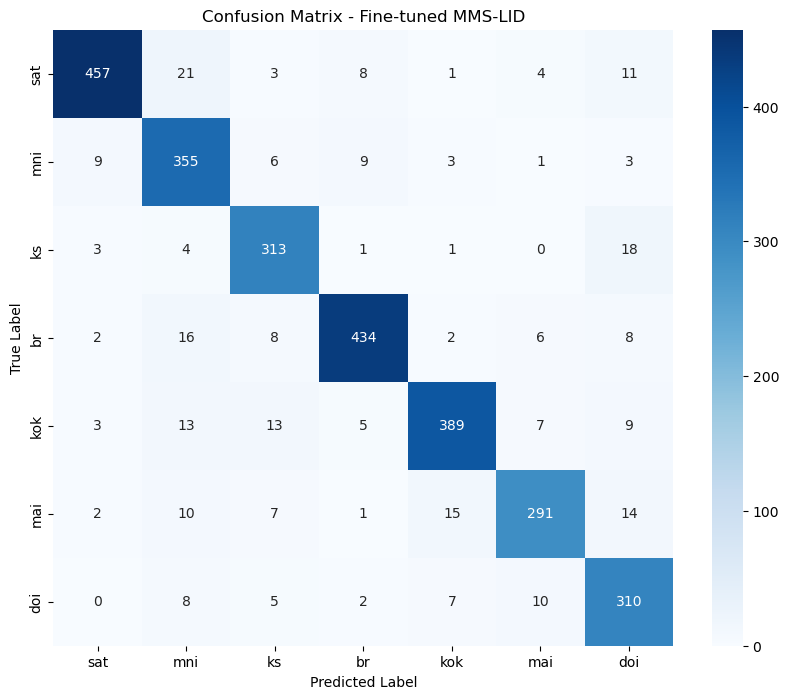


📊 Per-class Accuracy:
  sat (Santali): 0.905
  mni (Manipuri): 0.920
  ks (Kashmiri): 0.921
  br (Bodo): 0.912
  kok (Konkani): 0.886
  mai (Maithili): 0.856
  doi (Dogri): 0.906


In [12]:
# def plot_training_history(history):
#     """Plot training history"""
#     fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#     # Loss
#     axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
#     axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
#     axes[0].set_title('Training and Validation Loss')
#     axes[0].set_xlabel('Epoch')
#     axes[0].set_ylabel('Loss')
#     axes[0].legend()
#     axes[0].grid(True, alpha=0.3)

#     # Accuracy
#     axes[1].plot(history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
#     axes[1].set_title('Validation Accuracy')
#     axes[1].set_xlabel('Epoch')
#     axes[1].set_ylabel('Accuracy')
#     axes[1].legend()
#     axes[1].grid(True, alpha=0.3)

#     # Best accuracy line
#     best_acc = max(history['val_accuracy'])
#     best_epoch = history['val_accuracy'].index(best_acc)
#     axes[1].axhline(y=best_acc, color='red', linestyle='--', alpha=0.7,
#                     label=f'Best: {best_acc:.3f} (Epoch {best_epoch+1})')
#     axes[1].legend()

#     # Combined plot
#     ax2 = axes[2].twinx()

#     line1 = axes[2].plot(history['train_loss'], 'b-', marker='o', label='Train Loss', alpha=0.7)
#     line2 = axes[2].plot(history['val_loss'], 'r-', marker='s', label='Val Loss', alpha=0.7)
#     line3 = ax2.plot(history['val_accuracy'], 'g-', marker='^', label='Val Accuracy', alpha=0.7)

#     axes[2].set_xlabel('Epoch')
#     axes[2].set_ylabel('Loss', color='black')
#     ax2.set_ylabel('Accuracy', color='green')

#     # Combine legends
#     lines1 = line1 + line2
#     lines2 = line3
#     labels1 = [l.get_label() for l in lines1]
#     labels2 = [l.get_label() for l in lines2]
#     axes[2].legend(lines1 + lines2, labels1 + labels2, loc='center right')

#     axes[2].set_title('Training Overview')
#     axes[2].grid(True, alpha=0.3)

#     plt.tight_layout()
#     plt.show()

def final_evaluation():
    """Perform final evaluation"""
    print("📊 Final Evaluation")
    print("=" * 50)

    # Load best model
    checkpoint = torch.load('/NoumidaA/Notebooks/best_model.pt', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Validate on test set
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, collate_fn=collate_fn)

    _, test_accuracy, test_preds, test_labels = validate(model, test_loader, criterion, device)

    print(f"🎯 Test Accuracy: {test_accuracy:.4f}")

    # Classification report
    target_names = [f"{code} ({TARGET_LANGUAGES[code]})" for code in TARGET_LANGUAGES.keys()]
    report = classification_report(test_labels, test_preds, target_names=target_names)
    print(f"\n📈 Classification Report:")
    print(report)

    # Confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(test_labels, test_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=list(TARGET_LANGUAGES.keys()),
               yticklabels=list(TARGET_LANGUAGES.keys()))
    plt.title('Confusion Matrix - Fine-tuned MMS-LID')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Per-class accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    print(f"\n📊 Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        lang_code = list(TARGET_LANGUAGES.keys())[i]
        lang_name = TARGET_LANGUAGES[lang_code]
        print(f"  {lang_code} ({lang_name}): {acc:.3f}")

# Uncomment after training
# plot_training_history(history)
final_evaluation()
